## Классификация FashionMNIST

##### Автор: [Радослав Нейчев](https://www.linkedin.com/in/radoslav-neychev/), https://t.me/s/girafe_ai

In [1]:
# do not change the code in the block below
# __________start of block__________
import json
import os
import re

import numpy as np
import torch
import torchvision
from IPython.display import clear_output
from matplotlib import pyplot as plt
from torch import nn
from torch.nn import functional as F
from torchvision.datasets import FashionMNIST

# __________end of block__________

In [2]:
# do not change the code in the block below
# __________start of block__________


def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        layer_name, params = layer_str.split("(", 1)
        params = params.rstrip(")")
        layer_info["type"] = layer_name.strip()
        param_dict = {}
        for param in params.split(", "):
            if "=" in param:
                key, value = param.split("=")
                param_dict[key.strip()] = eval(value.strip())
            else:
                param_dict[param.strip()] = None
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict


# __________end of block__________

In [3]:
# do not change the code in the block below
# __________start of block__________
def get_predictions(model, eval_data, step=10):

    predicted_labels = []
    model.eval()
    with torch.no_grad():
        for idx in range(0, len(eval_data), step):
            y_predicted = model(eval_data[idx : idx + step].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())

    predicted_labels = torch.cat(predicted_labels)
    predicted_labels = ",".join([str(x.item()) for x in list(predicted_labels)])
    return predicted_labels


def get_accuracy(model, data_loader):
    predicted_labels = []
    real_labels = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            y_predicted = model(batch[0].to(device))
            predicted_labels.append(y_predicted.argmax(dim=1).cpu())
            real_labels.append(batch[1])

    predicted_labels = torch.cat(predicted_labels)
    real_labels = torch.cat(real_labels)
    accuracy_score = (predicted_labels == real_labels).type(torch.FloatTensor).mean()
    return accuracy_score


# __________end of block__________

Загрузите файл `hw_overfitting_data_dict.npy` (ссылка есть на странице с заданием), он понадобится для генерации посылок. Код ниже может его загрузить (но в случае возникновения ошибки скачайте и загрузите его вручную).


In [4]:
# !wget https://github.com/girafe-ai/ml-course/raw/24f_ysda/homeworks/hw_overfitting/hw_overfitting_data_dict -O hw_overfitting_data_dict.npy

In [5]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_overfitting_data_dict.npy"
), "Please, download `hw_overfitting_data_dict.npy` and place it in the working directory"

# __________end of block__________

Вернемся к задаче распознавания простых изображений, рассмотренной ранее. Но теперь будем работать с набором данных [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). В данном задании воспользуемся всем датасетом целиком.

__Ваша первая задача: реализовать весь пайплан обучения модели и добиться качества $\geq 88.5\%$ на тестовой выборке.__

Код для обучения модели в данном задании отсутствует. Присутствует лишь несколько тестов, которые помогут вам отладить свое решение. За примером можно обратиться к ноутбукам с предыдущих занятий.

In [6]:
CUDA_DEVICE_ID = 0  # change if needed

In [7]:
# do not change the code in the block below
# __________start of block__________
device = (
    torch.device(f"cuda:{CUDA_DEVICE_ID}") if torch.cuda.is_available() else torch.device("cpu")
)
# __________end of block__________

In [8]:
# do not change the code in the block below
# __________start of block__________

train_fmnist_data = FashionMNIST(
    ".", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
test_fmnist_data = FashionMNIST(
    ".", train=False, transform=torchvision.transforms.ToTensor(), download=True
)


train_data_loader = torch.utils.data.DataLoader(
    train_fmnist_data, batch_size=32, shuffle=True, num_workers=2
)

test_data_loader = torch.utils.data.DataLoader(
    test_fmnist_data, batch_size=32, shuffle=False, num_workers=2
)

In [9]:
train_fmnist_data

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: .
    Split: Train
    StandardTransform
Transform: ToTensor()

Text(0.5, 1.0, 'Image label: 0')

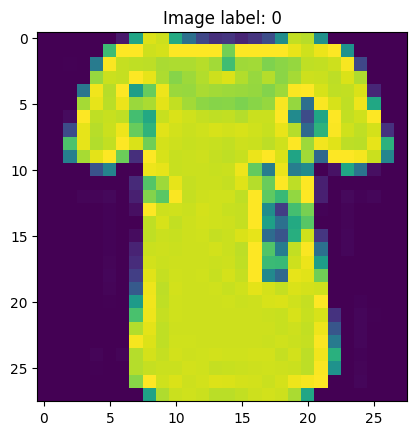

In [10]:
random_batch = next(iter(train_data_loader))
_image, _label = random_batch[0][0], random_batch[1][0]
plt.figure()
plt.imshow(_image.reshape(28, 28))
plt.title(f"Image label: {_label}")
# __________end of block__________

Постройте модель ниже. Пожалуйста, не стройте переусложненную сеть, не стоит делать ее глубже четырех слоев (можно и меньше). Ваша основная задача – обучить модель и получить качество на отложенной (тестовой выборке) не менее 88.5% accuracy.

__Внимание, ваша модель должна быть представлена именно переменной `model_task_1`. На вход ей должен приходить тензор размерностью (1, 28, 28).__

In [11]:
class MNISTNet(nn.Module):
    
    def __init__(self):
        super(MNISTNet, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )
        
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [12]:
class LeNet(nn.Module):
    
    def __init__(self):
        super(LeNet, self).__init__()
        
        self.linear_relu_stack = nn.Sequential(
            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), 
            # (28 + 2*2 - 5) / 1 + 1 = 28, 28, 6
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # (28 - 2)/2 + 1 = 14, 14, 6
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
            # 10, 10, 16
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5, 5, 16
            
            nn.Flatten(), # 5 * 5 * 16
            nn.Linear(5 * 5 * 16, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, 10),
        )
        
    def forward(self, x):
        # x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
# class AlexNet(nn.Module):
    
#     def __init__(self):
#         super(LeNet, self).__init__()
        
#         self.linear_relu_stack = nn.Sequential(
            
#             nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2), 
#             # (28 + 2*2 - 5) / 1 + 1 = 28, 28, 6
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # (28 - 2)/2 + 1 = 14, 14, 6
            
#             nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
#             # 10, 10, 16
#             nn.ReLU(),
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             # 5, 5, 16
            
#             nn.Flatten(), # 5 * 5 * 16
#             nn.Linear(5 * 5 * 16, 120),
#             nn.ReLU(),
#             nn.Linear(120, 84),
#             nn.ReLU(),
#             nn.Linear(84, 10),
#         )
        
#     def forward(self, x):
#         # x = self.flatten(x)
#         logits = self.linear_relu_stack(x)
#         return logits

In [13]:
# Creating model instance
model_task_1 = LeNet()
# your code here

Не забудьте перенести модель на выбранный `device`!

In [14]:
model_task_1.to(device)

LeNet(
  (linear_relu_stack): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=400, out_features=120, bias=True)
    (8): ReLU()
    (9): Linear(in_features=120, out_features=84, bias=True)
    (10): ReLU()
    (11): Linear(in_features=84, out_features=10, bias=True)
  )
)

Локальные тесты для проверки вашей модели доступны ниже:

In [15]:
# do not change the code in the block below
# __________start of block__________
assert model_task_1 is not None, "Please, use `model_task_1` variable to store your model"

try:
    x = random_batch[0].to(device)
    y = random_batch[1].to(device)

    # compute outputs given inputs, both are variables
    y_predicted = model_task_1(x)
except Exception as e:
    print("Something is wrong with the model")
    raise e


assert y_predicted.shape[-1] == 10, "Model should predict 10 logits/probas"

print("Everything seems fine!")
# __________end of block__________

Everything seems fine!


Настройте параметры модели на обучающей выборке. Также рекомендуем поработать с `learning rate`.

In [16]:
import torch.optim as optim

# your code here
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_task_1.parameters(), lr=1e-3)
epochs = 10

Также, напоминаем, что в любой момент можно обратиться к замечательной [документации](https://pytorch.org/docs/stable/index.html) и [обучающим примерам](https://pytorch.org/tutorials/).  

In [17]:
epochs = 10
train_losses = [0] * epochs
test_losses = [0] * epochs

from tqdm import tqdm 
def train(epochs):   
    for epoch in tqdm(range(epochs)):
        
        model_task_1.train()
        for batch, (X, y) in enumerate(train_data_loader):
            pred = model_task_1(X)
            loss = loss_fn(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_losses[epoch] += loss.item()
        
        model_task_1.eval()
        with torch.no_grad():
            for batch, (X, y) in enumerate(test_data_loader):
                pred = model_task_1(X)
                test_losses[epoch] += loss_fn(pred, y).item()

train(epochs=epochs)

100%|██████████| 10/10 [02:58<00:00, 17.84s/it]


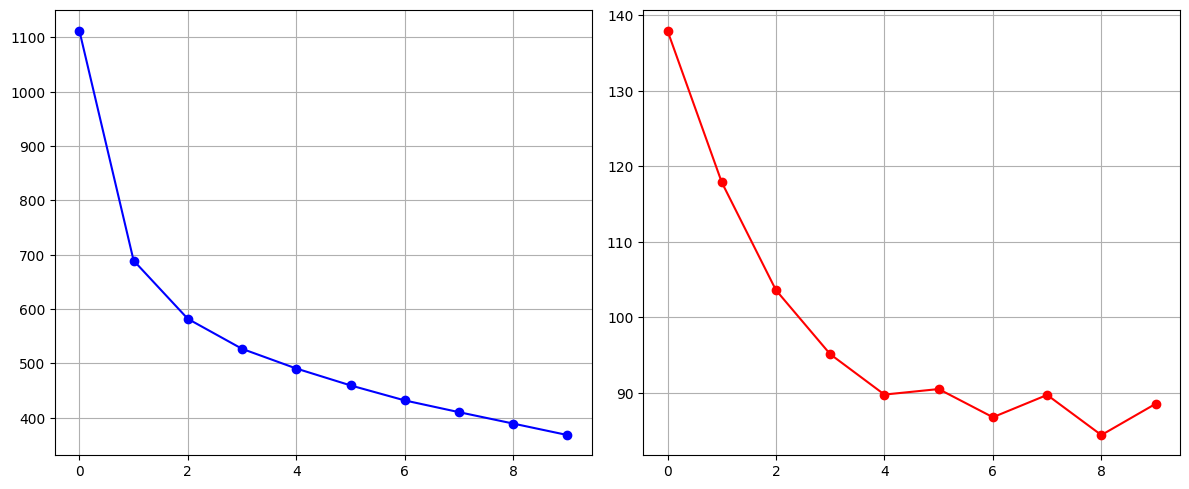

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) 
plt.plot(list(range(epochs)), train_losses, marker='o', color='b', label='train')
plt.grid(True)

plt.subplot(1, 2, 2) 
plt.plot(list(range(epochs)), test_losses, marker='o', color='r', label='test')
plt.grid(True)

plt.tight_layout()
plt.show()

Оценим качество классификации:

In [19]:
train_acc_task_1 = get_accuracy(model_task_1, train_data_loader)
print(f"Neural network accuracy on train set: {train_acc_task_1:3.5}")

Neural network accuracy on train set: 0.92945


In [20]:
test_acc_task_1 = get_accuracy(model_task_1, test_data_loader)
print(f"Neural network accuracy on test set: {test_acc_task_1:3.5}")

Neural network accuracy on test set: 0.8986


Проверка, что необходимые пороги пройдены:

In [21]:
assert test_acc_task_1 >= 0.885, "Train accuracy is below 0.885 threshold"
assert (
    train_acc_task_1 >= 0.905
), "Test accuracy is below 0.905 while test accuracy is fine. We recommend to check your model and data flow"

Обращаем внимане, код ниже предполагает, что ваша модель имеет содержится в переменной `model_task_1`, а файл `hw_fmnist_data_dict.npy` находится в той же директории, что и ноутбук (он доступен в репозитории).

In [32]:
# do not change the code in the block below
# __________start of block__________
assert os.path.exists(
    "hw_fmnist_data_dict.npy"
), "Please, download `hw_fmnist_data_dict.npy` and place it in the working directory"

loaded_data_dict = np.load("hw_fmnist_data_dict.npy", allow_pickle=True)

submission_dict = {
    "train_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["train"])
    ),
    "test_predictions_task_1": get_predictions(
        model_task_1, torch.FloatTensor(loaded_data_dict.item()["test"])
    ),
    "model_task_1": parse_pytorch_model(str(model_task_1)),
}

with open("submission_dict_fmnist_task_1.json", "w") as iofile:
    json.dump(submission_dict, iofile)
print("File saved to `submission_dict_fmnist_task_1.json`")
# __________end of block__________

File saved to `submission_dict_fmnist_task_1.json`


### Сдача задания
Сдайте сгенерированный файл в соответствующую задачу в соревновании, а именно:
    
* `submission_dict_task_1.json` в задачу Separation

На этом задание завершено. Поздравляем!

In [31]:
# do not change the code in the block below
# __________start of block__________


def parse_pytorch_model(model_str):
    def parse_layer(layer_str):
        layer_info = {}
        layer_name, params = layer_str.split("(", 1)
        params = params.rstrip(")")
        layer_info["type"] = layer_name.strip()
        param_dict = {}
        for param in params.split(", "):
            # print(param)
            if "=" in param:
                key, value = param.split("=")
                # print(key, value) 
                param_dict[key.strip()] = value.strip() # eval()
            else:
                param_dict[param.strip()] = None
        layer_info["parameters"] = param_dict
        return layer_info

    model_dict = {}
    lines = model_str.splitlines()
    model_name = lines[0].strip("()")
    model_dict["model_name"] = model_name
    model_dict["layers"] = []

    layer_regex = re.compile(r"\((\d+)\): (.+)")
    for line in lines[1:]:
        line = line.strip()
        match = layer_regex.match(line)
        if match:
            index, layer = match.groups()
            model_dict["layers"].append({"index": int(index), "layer": parse_layer(layer)})
    return model_dict


# __________end of block__________